In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import gc
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.stats import median_abs_deviation

In [2]:
adata = sc.read_10x_h5("../Data/square_008um/filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
adata

/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 310118 × 18085
    var: 'gene_ids', 'feature_types', 'genome'

In [3]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [4]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 310118 × 18085
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

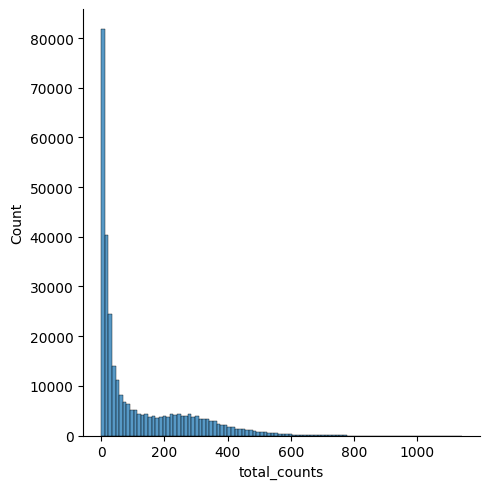

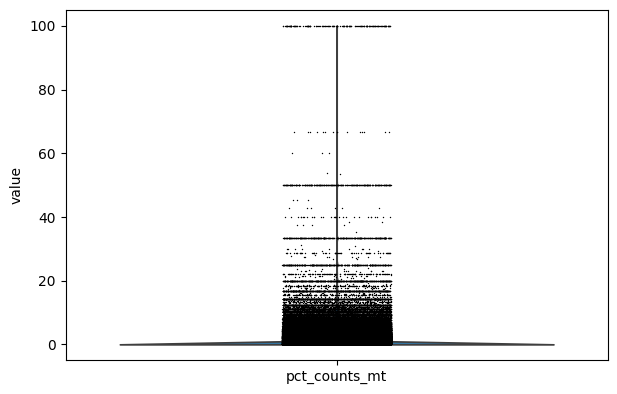

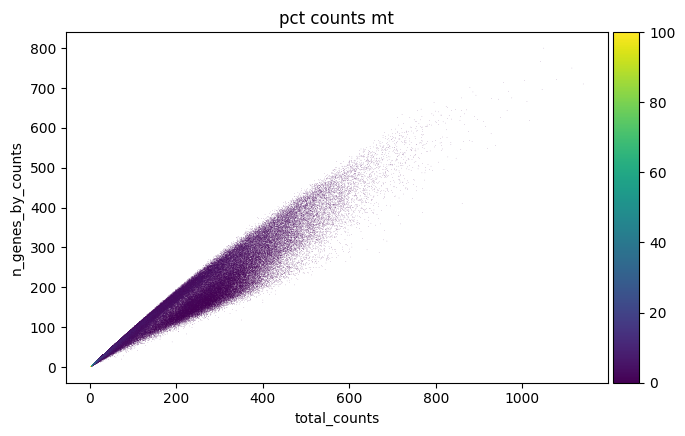

In [5]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [6]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [7]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    310118
Name: count, dtype: int64

In [8]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    298225
True      11893
Name: count, dtype: int64

In [9]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 310118
Number of cells after filtering of low quality cells: 298225


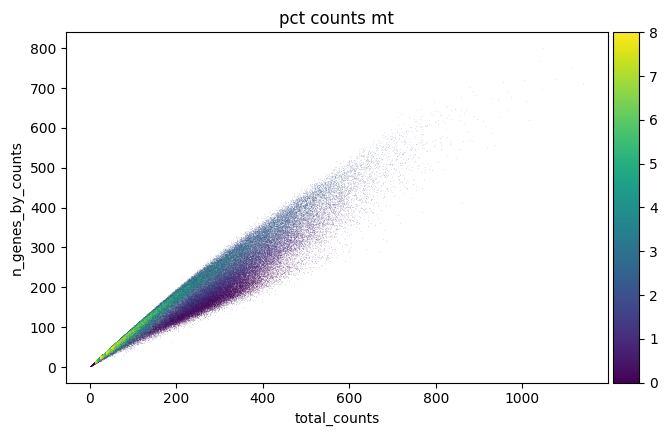

In [10]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Correction of ambient RNA(Connected to R)

In [11]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_76456/3659631106.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [12]:
%%R
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [13]:
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)

/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [14]:
adata

AnnData object with n_obs × n_vars = 298225 × 18085
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [15]:
adata_pp

AnnData object with n_obs × n_vars = 298225 × 18085
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [16]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_76456/1605676219.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_pp, key_added="soupx_groups")


In [17]:
# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

In [18]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

In [19]:
adata_raw = sc.read_10x_h5("../Data/square_008um/raw_feature_bc_matrix.h5")
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T

/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [20]:
# common genes
common_genes = adata_pp.var_names.intersection(adata_raw.var_names)

adata_raw_filtered = adata_raw[:, common_genes]

assert np.array_equal(adata_pp.var_names, adata_raw_filtered.var_names), "gene seq not same"

data_tod = adata_raw_filtered.X.T


In [21]:
print(set(cells) - set(adata_pp.obs_names))

set()


In [22]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
if (length(soupx_groups) != length(cells)) {
  stop("soupx_groups 的长度与细胞数不一致")
}
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

167 genes passed tf-idf cut-off and 157 soup quantile filter.  Taking the top 100.
Using 13941 independent estimates of rho.
Estimated global rho of 0.01
Expanding counts from 153 clusters to 298225 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


In [23]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

In [24]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 18085
Number of genes after cell filter: 14100


In [25]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

Loading required package: SeuratObject
Loading required package: sp
‘SeuratObject’ was built under R 4.4.0 but the current version is
4.4.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed
‘SeuratObject’ was built with package ‘Matrix’ 1.7.0 but the current
version is 1.7.1; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs,

In [26]:
data_mat = adata.X.T

In [27]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~25000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 31074 cells excluded from training.
iter=1, 38781 cells excluded from training.
iter=2, 39878 cells excluded from training.
Threshold found:0.091
59253 (19.9%) doublets called
In addition: Warning messages:
1: In .checkSCE(sce) :
  Some cells in `sce` have an extremely low read counts; note that these could trigger errors and might best be filtered out
2: In scDblFinder(SingleCellExperiment(list(counts = data_mat), )) :
  You are trying to run scDblFinder on a very large number of cells. If these are from different captures, please specify this using the `samples` argument.TRUE
3: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 1.1 GiB
4: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 1.2 GiB


In [28]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    238972
doublet     59253
Name: count, dtype: int64

In [29]:
adata.write("skin008_quality_control.h5ad")